<a href="https://colab.research.google.com/github/chaobai/Cousera-DeepLearning.AI-TensorFlow-Developer/blob/master/C4%20-%20Sequences%2C%20Time%20Series%20and%20Prediction/W2/Lab_3_deep_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

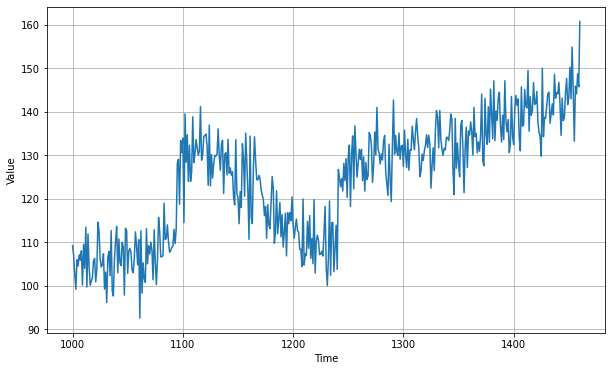

In [5]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=2)

Epoch 1/100
31/31 - 2s - loss: 467.6780 - 2s/epoch - 71ms/step
Epoch 2/100
31/31 - 0s - loss: 60.9638 - 139ms/epoch - 4ms/step
Epoch 3/100
31/31 - 0s - loss: 51.2878 - 123ms/epoch - 4ms/step
Epoch 4/100
31/31 - 0s - loss: 50.4811 - 126ms/epoch - 4ms/step
Epoch 5/100
31/31 - 0s - loss: 49.7628 - 138ms/epoch - 4ms/step
Epoch 6/100
31/31 - 0s - loss: 47.8046 - 130ms/epoch - 4ms/step
Epoch 7/100
31/31 - 0s - loss: 47.7414 - 133ms/epoch - 4ms/step
Epoch 8/100
31/31 - 0s - loss: 46.5403 - 129ms/epoch - 4ms/step
Epoch 9/100
31/31 - 0s - loss: 45.6837 - 131ms/epoch - 4ms/step
Epoch 10/100
31/31 - 0s - loss: 45.4913 - 128ms/epoch - 4ms/step
Epoch 11/100
31/31 - 0s - loss: 44.6752 - 124ms/epoch - 4ms/step
Epoch 12/100
31/31 - 0s - loss: 44.2808 - 132ms/epoch - 4ms/step
Epoch 13/100
31/31 - 0s - loss: 44.2564 - 132ms/epoch - 4ms/step
Epoch 14/100
31/31 - 0s - loss: 43.2440 - 127ms/epoch - 4ms/step
Epoch 15/100
31/31 - 0s - loss: 43.1614 - 135ms/epoch - 4ms/step
Epoch 16/100
31/31 - 0s - loss: 44.

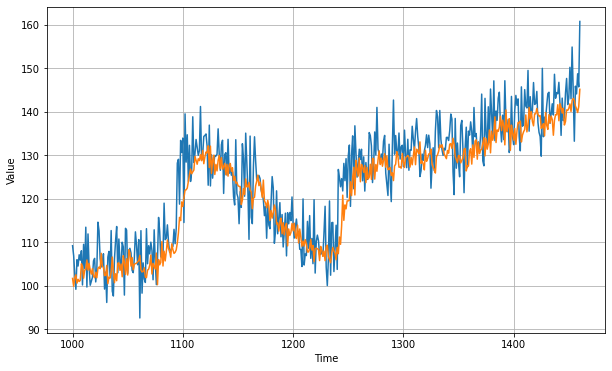

In [8]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.9444165

In [12]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
31/31 [==============================] - 1s 4ms/step - loss: 2149.8074 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 486.2131 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 94.3488 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 60.3100 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 59.3513 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 59.2961 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 59.2344 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 59.1423 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 59.1058 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 58.9830 - lr: 2.8184e-08
Epoch 11/100
31/

(1e-08, 0.001, 0.0, 300.0)

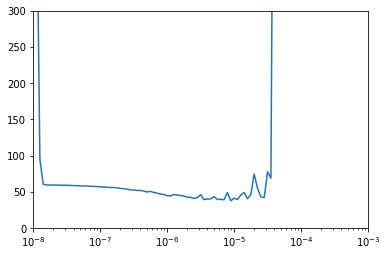

In [13]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [14]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

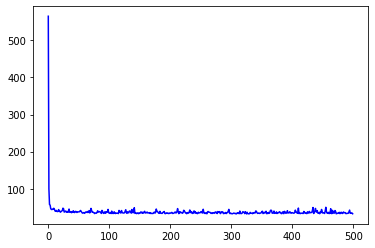

In [15]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[44.86830520629883, 40.30229949951172, 39.505985260009766, 41.825965881347656, 39.19478988647461, 38.60873794555664, 39.10166549682617, 43.95429229736328, 38.99152755737305, 39.5948486328125, 36.93306350708008, 38.894203186035156, 40.246620178222656, 41.37945556640625, 47.7563362121582, 46.48902130126953, 37.455081939697266, 37.6989631652832, 40.0562858581543, 39.34004211425781, 36.67650604248047, 39.21384811401367, 36.976680755615234, 37.39451599121094, 45.3723030090332, 36.90957260131836, 37.28575134277344, 38.369686126708984, 35.586971282958984, 37.38282012939453, 36.51044464111328, 40.86687469482422, 36.97555923461914, 35.955970764160156, 38.23006820678711, 39.238983154296875, 37.33090591430664, 36.19133377075195, 38.121253967285156, 37.785003662109375, 37.88336944580078, 38.024627685546875, 40.30181121826172, 41.623172760009766, 38.62819290161133, 36.492435455322266, 34.416107177734375, 35.33345413208008, 35.90877914428711, 33.97437286376953, 34.69324493408203, 37.405113220214844,

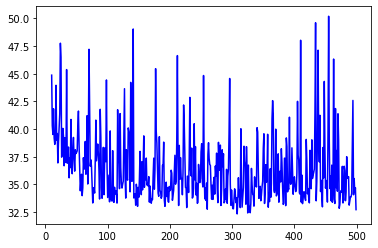

In [16]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

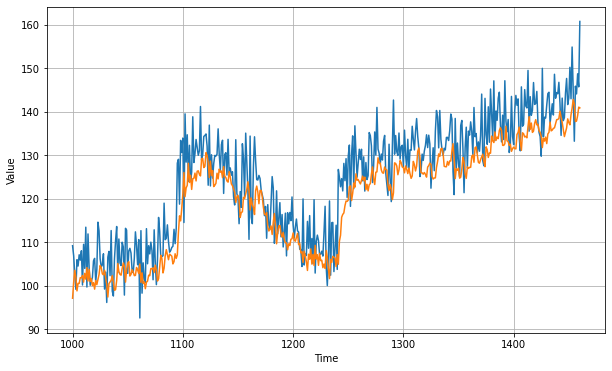

In [17]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.8148518